In [22]:
import os
import numpy as np
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from drain3.template_miner import TemplateMiner
from drain3.file_persistence import FilePersistence
from drain3.template_miner_config import TemplateMinerConfig
from scipy.sparse._csr import csr_matrix
from gensim.models import Word2Vec

from utils import (
    preprocess_logs,
    get_weighted_word_embedding_vector,
    get_line_idf_features,
    plot_silhouette_scores,
)

nltk.download("stopwords")

### Preprocessing for parsed logs (basic or reduced preprocessing)

In [ ]:
do_preprocessing = False
preprocessing_method = 2    # 1 or 2

parsed_logs_path = os.path.join(
    ""
)
failed_cases_path = os.path.join(
    parsed_logs_path, ""
)
passed_cases_path = os.path.join(
    parsed_logs_path, ""
)
save_path = os.path.join("")
df_save_name = f"preprocessed_container_logs_{preprocessing_method}.parquet"

if do_preprocessing:
    if not os.path.isdir(save_path):
        os.mkdir(save_path)

    if not os.path.exists(os.path.join(save_path, df_save_name)):
        df = pd.DataFrame(
            {
                "test_case_id": [],
                "result": [],
                "concatenated_raw_log": [],
                "concatenated_preprocessed_log_message": [],
                "all_logging_entities": [],
            }
        )
    else:
        df = pd.read_parquet(os.path.join(save_path, df_save_name))

    ps = PorterStemmer()
    df = preprocess_logs(failed_cases_path, df, method=preprocessing_method, stemmer=ps)
    df = preprocess_logs(passed_cases_path, df, method=preprocessing_method, stemmer=ps)
    df.to_parquet(os.path.join(save_path, df_save_name))
else:
    df = pd.read_parquet(os.path.join(save_path, df_save_name))

df.dropna(subset="concatenated_preprocessed_log_message", inplace=True)

### Find failure specific log lines and calculate line-IDF features

In [ ]:
calculate_features = False

failed_cases_persistence = FilePersistence(
    os.path.join(
        "",
    )
)
passed_cases_persistence = FilePersistence(
    os.path.join(
        "",
    )
)
config = TemplateMinerConfig()
config.load(os.path.join("..", "log_template_miner_config", "drain3.ini"))
failed_cases_template_miner = TemplateMiner(failed_cases_persistence, config)
passed_cases_template_miner = TemplateMiner(passed_cases_persistence, config)

if calculate_features:
    features_failed_cases_failure_specific_templates = get_line_idf_features(
        failed_cases_path,
        failed_cases_template_miner,
        passed_cases_template_miner,
    )
    features_passed_cases_failure_specific_templates = get_line_idf_features(
        passed_cases_path,
        failed_cases_template_miner,
        passed_cases_template_miner,
    )
    features = pd.concat(
        [
            features_failed_cases_failure_specific_templates,
            features_passed_cases_failure_specific_templates,
        ]
    )
    try:
        df = (
            df.set_index("test_case_id")
            .join(
                features.set_index("resultId")[
                    ["feature_vector", "log_template_logging_entities", "log_messages"]
                ]
            )
            .reset_index()
        )
    except ValueError:
        df.drop(
            ["feature_vector", "log_template_logging_entities", "log_messages"],
            axis=1,
            inplace=True,
        )
        df = (
            df.set_index("test_case_id")
            .join(
                features.set_index("resultId")[
                    ["feature_vector", "log_template_logging_entities", "log_messages"]
                ]
            )
            .reset_index()
        )
    df.to_parquet(
        os.path.join(
            save_path,
            "preprocessed_container_logs_with_fail_specific_event_template_idf_features.parquet",
        )
    )
else:
    df = pd.read_parquet(
        os.path.join(
            save_path,
            "preprocessed_container_logs_with_fail_specific_event_template_idf_features.parquet",
        )
    )


def non_zero_vectors(series_of_lists):
    non_zero = []
    for i in series_of_lists:
        if np.count_nonzero(i) != 0:
            non_zero.append(True)
        else:
            non_zero.append(False)
    return pd.Series(non_zero)


# Include only cases that contain a failure specific event template
df = df.where(non_zero_vectors(df["feature_vector"])).dropna(subset="feature_vector")

feature_vector = df["feature_vector"]
feature_vector = np.stack(feature_vector.values)
feature_vector = normalize(feature_vector, norm="l2")

# Remove columns containing only zeros (feature value is zero for all samples) from feature vector
event_templates_failed_cases = [
    cluster.get_template() for cluster in failed_cases_template_miner.drain.clusters
]
event_templates_passed_cases = [
    cluster.get_template() for cluster in passed_cases_template_miner.drain.clusters
]

failure_templates = [
    template
    for template in event_templates_failed_cases
    if template not in event_templates_passed_cases
]

feature_vector_reduced = np.zeros((feature_vector.shape[0], len(failure_templates)))
i = 0
for j in range(feature_vector.shape[1]):
    if np.max(feature_vector[:, j]) > 0:
        feature_vector_reduced[:, i] = feature_vector[:, j]
        i += 1
feature_vector = feature_vector_reduced
pd.DataFrame(feature_vector).to_parquet(f"container_logs_line_idf_features.parquet")

### Calculate other features (TF-IDF and Word2Vec weighted by TF-IDF with basic and reduced preprocessing)

In [11]:
used_features = "TF-IDF"    # 'TF-IDF' or 'Word2Vec+TF-IDF'
preprocessing_method = 2    # 1 or 2
min_df = 5


ps = PorterStemmer()
preprocessed_log_messages = df["concatenated_preprocessed_log_message"]

if preprocessing_method == 1:
    vectorizer = TfidfVectorizer(min_df=min_df)
elif preprocessing_method == 2:
    vectorizer = TfidfVectorizer(
        token_pattern=r"(?u)\b\w[\w|:|/|-|.]+\b", min_df=min_df
    )   # Token pattern according to preprocessing method 2
else:
    raise ValueError("Invalid preprocessing method, must be 1 or 2.")

if used_features == "TF-IDF":
    feature_vector = vectorizer.fit_transform(preprocessed_log_messages)
    pd.DataFrame(feature_vector).to_parquet(f"container_logs_tfidf_{preprocessing_method}_features.parquet")
elif used_features == "Word2Vec+TF-IDF":
    vectorizer.fit(preprocessed_log_messages)
    tokens = preprocessed_log_messages.apply(lambda x: word_tokenize(x))
    model = Word2Vec(tokens)
    feature_vector = preprocessed_log_messages.apply(
        lambda x: get_weighted_word_embedding_vector(x, model, vectorizer)
    )
    feature_vector = np.stack(feature_vector.values)
    pd.DataFrame(feature_vector).to_parquet(f"container_logs_word2vec_tfidf_{preprocessing_method}_features.parquet")

### Load calculated and saved feature vectors

In [16]:
features_line_idf = pd.read_parquet("container_logs_line_idf_features.parquet").to_numpy()
features_tfidf_1 = pd.read_parquet("container_logs_tfidf_1_features.parquet").to_numpy()
features_tfidf_2 = pd.read_parquet("container_logs_tfidf_2_features.parquet").to_numpy()
features_word2vec_tfidf_1 = pd.read_parquet("container_logs_word2vec_tfidf_1_features.parquet").to_numpy()
features_word2vec_tfidf_2 = pd.read_parquet("container_logs_word2vec_tfidf_2_features.parquet").to_numpy()

features = [features_line_idf, features_tfidf_1, features_tfidf_2, features_word2vec_tfidf_1, features_word2vec_tfidf_2]

### Plot silhouette scores

100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


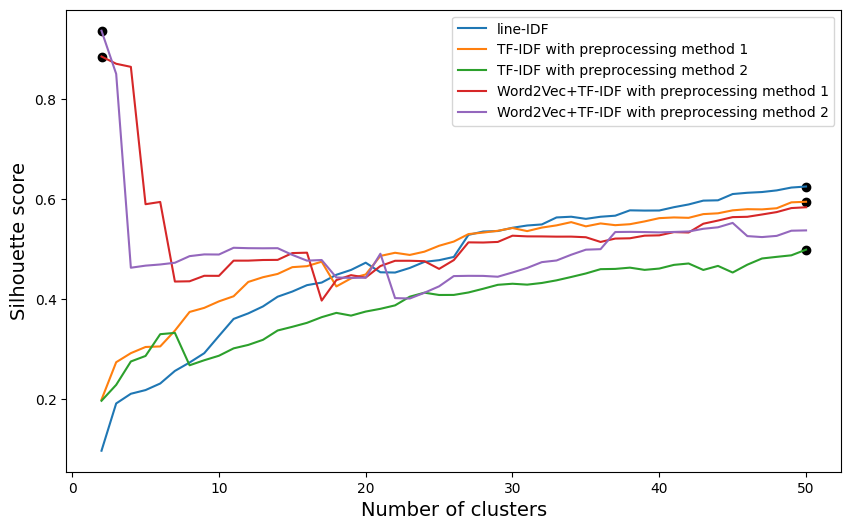

Number of clusters with max silhouette scores: [50, 50, 50, 2, 2]


In [17]:
plot_silhouette_scores(
    features,
    min_k=1,
    max_k=50,
    legend_labels=[
        "line-IDF",
        "TF-IDF with preprocessing method 1",
        "TF-IDF with preprocessing method 2",
        "Word2Vec+TF-IDF with preprocessing method 1",
        "Word2Vec+TF-IDF with preprocessing method 2",
    ]
)

### Clustering with line-IDF

Cluster sizes:
 [246, 384, 137, 14, 117, 98, 30, 37, 79, 85, 95, 49, 98, 66, 250, 12, 48, 59, 79, 18, 40, 63, 46, 33, 27, 30, 156, 55, 28, 36, 24, 119, 32, 21, 7, 41, 43, 48, 91, 43, 57, 36, 47, 23, 52, 46, 10, 13, 34, 9]
Silhouette score: 0.6252852133804289


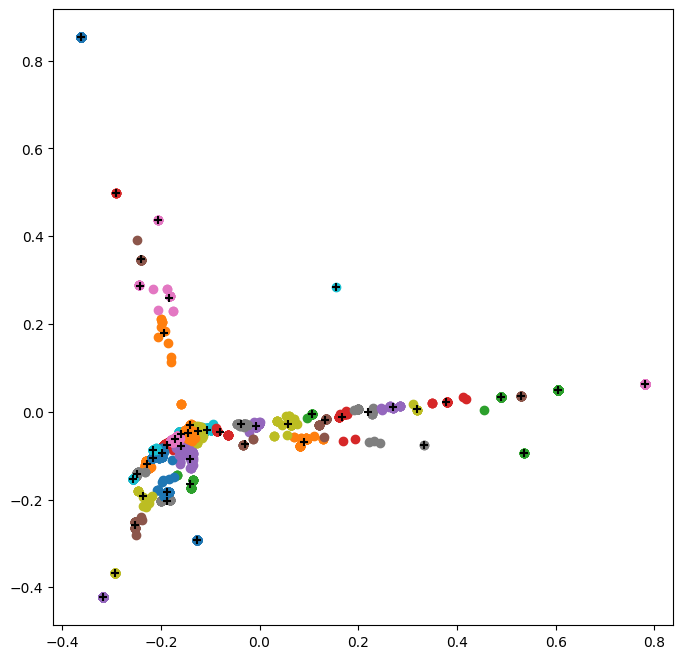

In [26]:
k = 50
feature_vector = features_line_idf

kmeans = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters = kmeans.fit_predict(feature_vector)

size_of_clusters = [np.count_nonzero(clusters == i) for i in range(k)]
print("Cluster sizes:\n", size_of_clusters)

score = silhouette_score(feature_vector, clusters, metric="euclidean")
print("Silhouette score:", score)

# Visualization using PCA
pca = PCA(2)
if isinstance(feature_vector, csr_matrix):
    transformed_features = pca.fit_transform(np.asarray(feature_vector.todense()))
else:
    transformed_features = pca.fit_transform(np.asarray(feature_vector))

kmeans_2_dim = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters_2_dim = kmeans_2_dim.fit_predict(transformed_features)

plt.figure(figsize=(8, 8))
for i in range(k):
    plt.scatter(
        transformed_features[clusters_2_dim == i, 0],
        transformed_features[clusters_2_dim == i, 1],
        label=i,
    )
plt.scatter(
    kmeans_2_dim.cluster_centers_[:, 0],
    kmeans_2_dim.cluster_centers_[:, 1],
    color="black",
    marker="+",
    label="centroid",
)
plt.show()

### Clustering with TF-IDF and basic preprocessing

Cluster sizes:
 [243, 43, 20, 137, 62, 406, 119, 61, 16, 39, 49, 118, 33, 22, 56, 89, 37, 31, 46, 19, 410, 36, 53, 54, 29, 22, 52, 39, 66, 21, 88, 40, 16, 63, 62, 86, 85, 16, 28, 91, 66, 12, 52, 49, 30, 13, 51, 14, 15, 6]
Silhouette score: 0.5947540139674926


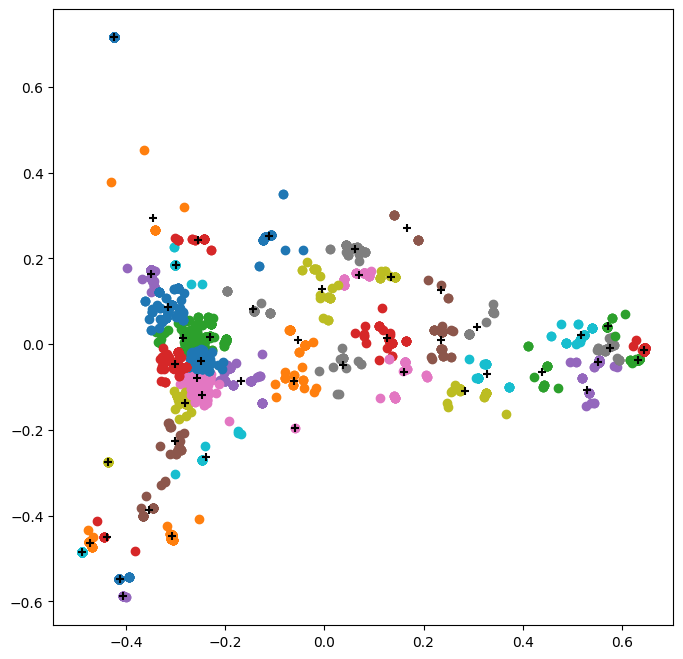

In [27]:
k = 50
feature_vector = features_tfidf_1

kmeans = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters = kmeans.fit_predict(feature_vector)

size_of_clusters = [np.count_nonzero(clusters == i) for i in range(k)]
print("Cluster sizes:\n", size_of_clusters)

score = silhouette_score(feature_vector, clusters, metric="euclidean")
print("Silhouette score:", score)

# Visualization using PCA
pca = PCA(2)
if isinstance(feature_vector, csr_matrix):
    transformed_features = pca.fit_transform(np.asarray(feature_vector.todense()))
else:
    transformed_features = pca.fit_transform(np.asarray(feature_vector))

kmeans_2_dim = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters_2_dim = kmeans_2_dim.fit_predict(transformed_features)

plt.figure(figsize=(8, 8))
for i in range(k):
    plt.scatter(
        transformed_features[clusters_2_dim == i, 0],
        transformed_features[clusters_2_dim == i, 1],
        label=i,
    )
plt.scatter(
    kmeans_2_dim.cluster_centers_[:, 0],
    kmeans_2_dim.cluster_centers_[:, 1],
    color="black",
    marker="+",
    label="centroid",
)
plt.show()

### Clustering with TF-IDF and reduced preprocessing

Cluster sizes:
 [241, 54, 87, 30, 53, 34, 119, 81, 113, 39, 87, 63, 39, 117, 361, 49, 16, 21, 41, 21, 47, 4, 46, 36, 85, 83, 31, 47, 80, 7, 71, 71, 37, 46, 61, 29, 30, 25, 63, 13, 55, 41, 330, 15, 84, 73, 52, 10, 13, 60]
Silhouette score: 0.49884889136488897


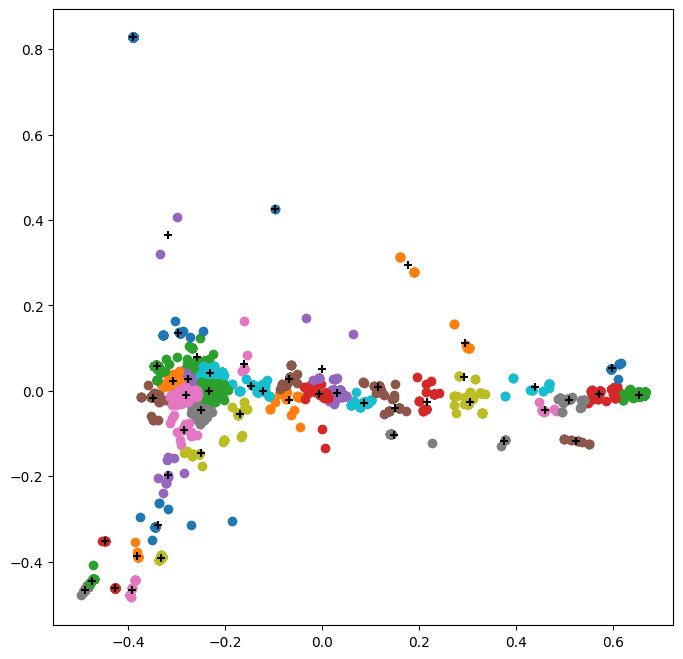

In [28]:
k = 50
feature_vector = features_tfidf_2

kmeans = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters = kmeans.fit_predict(feature_vector)

size_of_clusters = [np.count_nonzero(clusters == i) for i in range(k)]
print("Cluster sizes:\n", size_of_clusters)

score = silhouette_score(feature_vector, clusters, metric="euclidean")
print("Silhouette score:", score)

# Visualization using PCA
pca = PCA(2)
if isinstance(feature_vector, csr_matrix):
    transformed_features = pca.fit_transform(np.asarray(feature_vector.todense()))
else:
    transformed_features = pca.fit_transform(np.asarray(feature_vector))

kmeans_2_dim = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters_2_dim = kmeans_2_dim.fit_predict(transformed_features)

plt.figure(figsize=(8, 8))
for i in range(k):
    plt.scatter(
        transformed_features[clusters_2_dim == i, 0],
        transformed_features[clusters_2_dim == i, 1],
        label=i,
    )
plt.scatter(
    kmeans_2_dim.cluster_centers_[:, 0],
    kmeans_2_dim.cluster_centers_[:, 1],
    color="black",
    marker="+",
    label="centroid",
)
plt.show()

### Clustering with Word2Vec weighted by TF-IDF and basic preprocessing

Cluster sizes:
 [3242, 69]
Silhouette score: 0.8857236


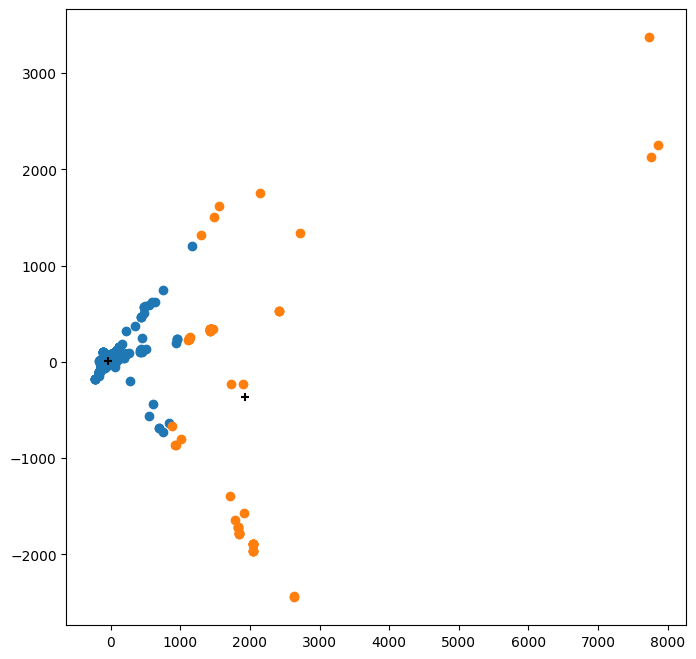

In [29]:
k = 2
feature_vector = features_word2vec_tfidf_1

kmeans = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters = kmeans.fit_predict(feature_vector)

size_of_clusters = [np.count_nonzero(clusters == i) for i in range(k)]
print("Cluster sizes:\n", size_of_clusters)

score = silhouette_score(feature_vector, clusters, metric="euclidean")
print("Silhouette score:", score)

# Visualization using PCA
pca = PCA(2)
if isinstance(feature_vector, csr_matrix):
    transformed_features = pca.fit_transform(np.asarray(feature_vector.todense()))
else:
    transformed_features = pca.fit_transform(np.asarray(feature_vector))

kmeans_2_dim = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters_2_dim = kmeans_2_dim.fit_predict(transformed_features)

plt.figure(figsize=(8, 8))
for i in range(k):
    plt.scatter(
        transformed_features[clusters_2_dim == i, 0],
        transformed_features[clusters_2_dim == i, 1],
        label=i,
    )
plt.scatter(
    kmeans_2_dim.cluster_centers_[:, 0],
    kmeans_2_dim.cluster_centers_[:, 1],
    color="black",
    marker="+",
    label="centroid",
)
plt.show()

### Clustering with Word2Vec weighted by TF-IDF and reduced preprocessing

Cluster sizes:
 [3283, 28]
Silhouette score: 0.93738264


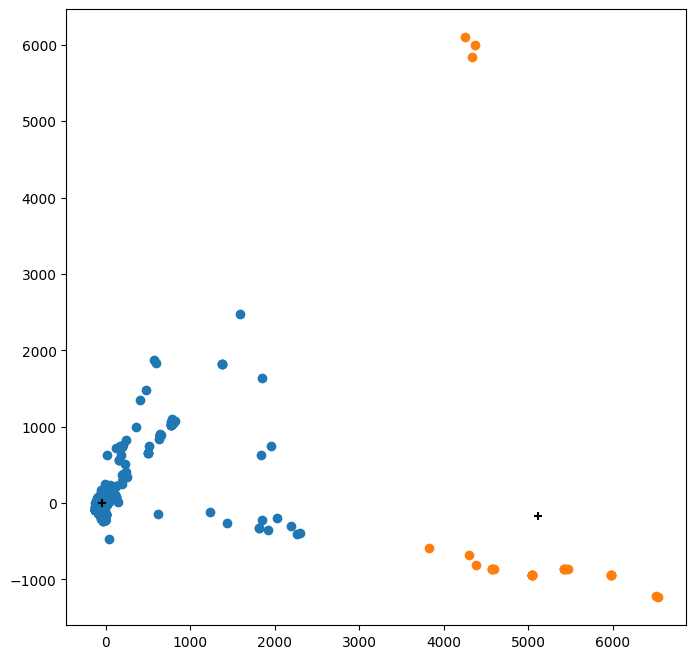

In [30]:
k = 2
feature_vector = features_word2vec_tfidf_2

kmeans = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters = kmeans.fit_predict(feature_vector)

size_of_clusters = [np.count_nonzero(clusters == i) for i in range(k)]
print("Cluster sizes:\n", size_of_clusters)

score = silhouette_score(feature_vector, clusters, metric="euclidean")
print("Silhouette score:", score)

# Visualization using PCA
pca = PCA(2)
if isinstance(feature_vector, csr_matrix):
    transformed_features = pca.fit_transform(np.asarray(feature_vector.todense()))
else:
    transformed_features = pca.fit_transform(np.asarray(feature_vector))

kmeans_2_dim = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters_2_dim = kmeans_2_dim.fit_predict(transformed_features)

plt.figure(figsize=(8, 8))
for i in range(k):
    plt.scatter(
        transformed_features[clusters_2_dim == i, 0],
        transformed_features[clusters_2_dim == i, 1],
        label=i,
    )
plt.scatter(
    kmeans_2_dim.cluster_centers_[:, 0],
    kmeans_2_dim.cluster_centers_[:, 1],
    color="black",
    marker="+",
    label="centroid",
)
plt.show()